# Content Validity Analysis Using Aiken’s V

This notebook performs a full analysis of content validity based on expert judgment, using **Aiken’s V coefficient** and its 95% confidence interval. The dataset includes expert ratings on educational items categorized under two content dimensions: **Relevance** and **Wording**.



# 🧪 Aiken’s V Analysis
This notebook performs a content validity analysis using Aiken’s V coefficient for an academic tutoring instrument designed to gather responses from students.

In [10]:
# 📂 Mount Google Drive to access datasets and resources stored in 'MyDrive'
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# ==========================================================================
# Load libraries and import CSV files
# ==========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from IPython.display import display, Markdown

# Load datasets from Google Drive
df = pd.read_csv('/content/drive/MyDrive/Tutorias_art_1_Aiken/demo_judges.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Tutorias_art_1_Aiken/data_Aiken_Tutoring.csv')


## 👤 Expert Judges Characterization

In [12]:
import pandas as pd
from tabulate import tabulate

# Total number of participants
n = len(df)

# List where the summary table will be built
summary_table = []

# Function to add categorical blocks
def add_block(variable, variable_name):
    summary_table.append([f"**{variable_name}**", "", ""])
    counts = df[variable].value_counts().sort_index()
    for category, freq in counts.items():
        percentage = round((freq / n) * 100, 1)
        summary_table.append(["", f"{category}", f"{freq} ({percentage}%)"])

# Blocks of categorical variables
add_block("sexo", "Sex")
add_block("grado_academico", "Highest academic degree")
add_block("especializacion", "Specialization")
add_block("experiencia_profesional", "Type of (main) professional experience")

# Numeric variable block: years of experience
summary_table.append(["**Years of experience**", "", ""])
summary_table.append(["", "Median (Q1, Q3)", f"{df['anios_experiencia'].median()} ({df['anios_experiencia'].quantile(0.25)}, {df['anios_experiencia'].quantile(0.75)})"])
summary_table.append(["", "Mean (SD)", f"{round(df['anios_experiencia'].mean(),1)} ({round(df['anios_experiencia'].std(),1)})"])
summary_table.append(["", "Min, Max", f"{df['anios_experiencia'].min()}, {df['anios_experiencia'].max()}"])

# Experience in instrument validation
add_block("exp_valid_inst", "Do you have experience in instrument validation?")

# Create final DataFrame
table_df = pd.DataFrame(summary_table, columns=["Variable", "Category", f"n={n}"])

# Display as Markdown table (without index)
print("### Table 3. Characterization of expert judges\n")
print(tabulate(table_df, headers="keys", tablefmt="github", showindex=False))

### Table 3. Characterization of expert judges

| Variable                                             | Category               | n=18              |
|------------------------------------------------------|------------------------|-------------------|
| **Sex**                                              |                        |                   |
|                                                      | Female                 | 10 (55.6%)        |
|                                                      | Male                   | 8 (44.4%)         |
| **Highest academic degree**                          |                        |                   |
|                                                      | Master                 | 13 (72.2%)        |
|                                                      | PhD                    | 5 (27.8%)         |
| **Specialization**                                   |                        |                   |
|                                 

## 🧮 Statistical Functions: Aiken’s V and Confidence Intervals

In [5]:
def compute_aiken_v(values, k):
    """
    Compute Aiken's V coefficient for content validity.

    Parameters:
    - values: array-like, expert ratings for a given item (e.g., integers from 1 to k)
    - k: int, maximum value of the rating scale (e.g., 4 for a 4-point Likert scale)

    Returns:
    - V: float, Aiken's V coefficient
    """
    N = len(values)  # Number of expert raters
    V = sum(values - 1) / (N * (k - 1))  # Aiken's formula
    return V

def compute_aiken_ci(V, n, k, confidence=0.95):
    """
    Compute the confidence interval for Aiken's V using the formula by Penfield & Giacobbi (2004).

    Parameters:
    - V: float, Aiken's V value
    - n: int, number of raters
    - k: int, number of points on the rating scale
    - confidence: float, desired confidence level (default = 0.95)

    Returns:
    - (L, U): tuple of floats, lower and upper bounds of the confidence interval
    """
    z = norm.ppf(1 - (1 - confidence) / 2)  # Z-score for the specified confidence level

    # Intermediate term inside the square root of the CI formula
    sqrt_term = np.sqrt(4 * n * k * V * (1 - V) + z**2)

    # Compute lower (L) and upper (U) bounds of the confidence interval
    L = (2 * n * k * V + z**2 - z * sqrt_term) / (2 * (n * k + z**2))
    U = (2 * n * k * V + z**2 + z * sqrt_term) / (2 * (n * k + z**2))

    return (L, U)

## 📊 Aiken’s V Calculation by Item

In [6]:
# Reshape the dataset to long format for item-level analysis
lf2 = df2.melt(id_vars='dimension', var_name='item', value_name='valor')

# Define number of response options on the rating scale (e.g., 4-point scale)
k = 4

# Confidence level for interval estimation
confianza = 0.95

# Compute mean and number of raters per item-dimension combination
resultados = (
    lf2.groupby(['dimension', 'item'])
    .agg(promedio=('valor', 'mean'), n=('valor', 'count'))  # mean rating and number of raters
    .reset_index()
)

# Calculate Aiken’s V for each item
resultados['V'] = lf2.groupby(['dimension', 'item'])['valor'].apply(lambda x: compute_aiken_v(x.values, k)).values

# Compute confidence intervals for Aiken’s V
resultados[['lim_inf', 'lim_sup']] = resultados.apply(
    lambda row: pd.Series(compute_aiken_ci(row['V'], row['n'], k, confianza)), axis=1
)

# Generate frequency counts for each response value (1–4) per item
frecuencias = (
    lf2.groupby(['dimension', 'item', 'valor'])
    .size()
    .unstack(fill_value=0)  # create one column per value (1, 2, 3, 4)
    .reset_index()
)

# Merge frequencies with Aiken’s V results into one final table
resultados_final = pd.merge(resultados, frecuencias, on=['dimension', 'item'], how='left').fillna(0)

# Reorder columns for presentation: dimension, item, frequencies, mean, V, CI
cols_order = ['dimension', 'item', 1, 2, 3, 4, 'promedio', 'V', 'lim_inf', 'lim_sup']
resultados_final = resultados_final[cols_order]

# Round numeric results to 3 decimal places
resultados_final[['promedio', 'V', 'lim_inf', 'lim_sup']] = resultados_final[['promedio', 'V', 'lim_inf', 'lim_sup']].round(3)

# Display final results table
display(Markdown("### Final results of Aiken’s V analysis"))
display(resultados_final)


### Final results of Aiken’s V analysis

,dimension,item,1,2,3,4,promedio,V,lim_inf,lim_sup
0,relevance,i01,0,0,2,18,3.90,0.967,0.901,0.989
1,relevance,i02,2,2,1,15,3.45,0.817,0.718,0.886
2,relevance,i03,0,1,4,15,3.70,0.900,0.815,0.948
3,relevance,i04,0,0,5,15,3.75,0.917,0.835,0.960
4,relevance,i05,2,2,3,13,3.35,0.783,0.681,0.859
5,relevance,i06,0,0,3,17,3.85,0.950,0.878,0.980
6,relevance,i07,0,1,3,16,3.75,0.917,0.835,0.960
7,relevance,i08,0,0,3,17,3.85,0.950,0.878,0.980
8,relevance,i09,3,1,7,9,3.10,0.700,0.592,0.789
9,relevance,i10,1,0,2,17,3.75,0.917,0.835,0.960


## 📈 Visualization of Aiken’s V and Confidence Intervals

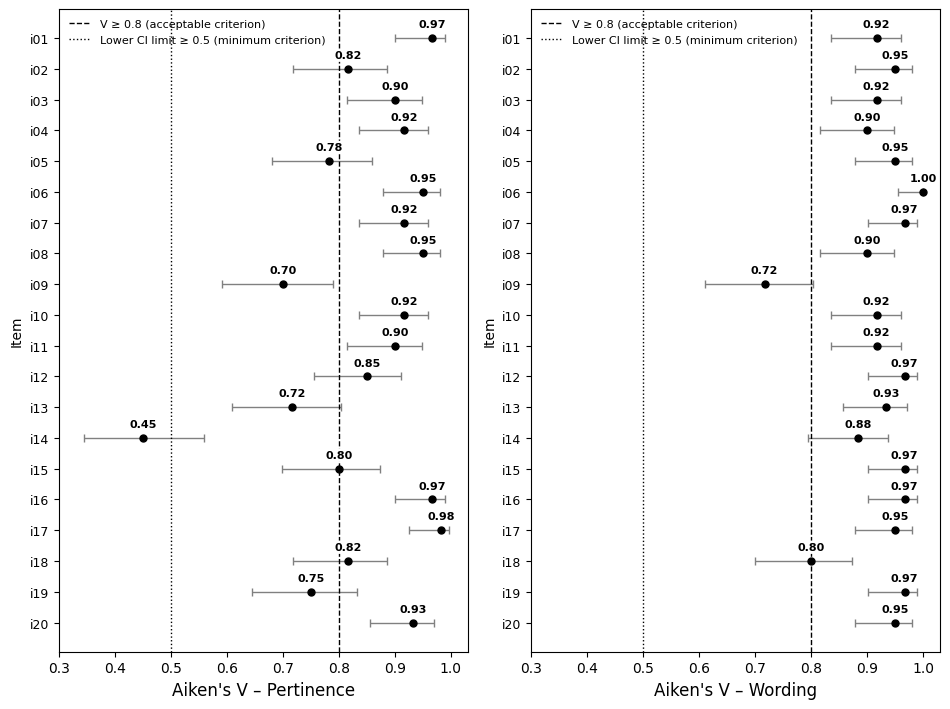

In [13]:
import matplotlib.pyplot as plt

# Dictionary for translating dimension titles
titulo_dim = {
    'relevance': 'Pertinence',
    'wording': 'Wording'
}

# Update default matplotlib parameters for consistent black styling
plt.rcParams.update({
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'text.color': 'black',
    'axes.labelcolor': 'black'
})

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9.6, 7.2), sharex=True)

# Loop through each dimension ('relevance' and 'wording')
for ax, dimension in zip(axes, ['relevance', 'wording']):
    # Filter data for the current dimension and reset the index
    subset = resultados[resultados['dimension'] == dimension].copy()
    subset = subset.reset_index(drop=True)
    subset['y_pos'] = subset.index  # y-axis position for each item

    # Plot points with error bars representing confidence intervals
    ax.errorbar(
        subset['V'], subset['y_pos'],
        xerr=[subset['V'] - subset['lim_inf'], subset['lim_sup'] - subset['V']],
        fmt='o', color='black', ecolor='gray', elinewidth=1, capsize=3, markersize=5
    )

    # Add reference lines for interpretation thresholds
    ax.axvline(0.8, color='black', linestyle='--', linewidth=1,
               label='V ≥ 0.8 (acceptable criterion)')
    ax.axvline(0.5, color='black', linestyle=':', linewidth=1,
               label='Lower CI limit ≥ 0.5 (minimum criterion)')

    # Add value labels with white background near each point
    for _, row in subset.iterrows():
        ax.text(
            row['V'], row['y_pos'] - 0.35, f"{row['V']:.2f}",
            ha='center', fontsize=8, color='black', weight='bold',
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15')
        )

    # Set y-axis labels and positions
    ax.set_yticks(subset['y_pos'])
    ax.set_yticklabels(subset['item'], fontsize=9)
    ax.set_xlabel(f"Aiken's V – {titulo_dim[dimension]}", fontsize=12)
    ax.set_ylabel("Item", fontsize=10)
    ax.invert_yaxis()  # Items are listed from top to bottom

    # Automatically adjust x-axis limits based on data
    x_max = max(subset['lim_sup'].max(), 1.0) + 0.03
    ax.set_xlim(0.3, x_max)

    # Display legend
    ax.legend(loc='upper left', fontsize=8, frameon=False)

# Optimize layout spacing
plt.tight_layout()

# Export the final figure in both PDF and high-resolution PNG formats
plt.savefig("V_Aiken_final.pdf", format='pdf', bbox_inches='tight')
plt.savefig("V_Aiken_final.png", format='png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

### 📌 Reproducibility Notes

- Designed for execution in [Google Colab](https://colab.research.google.com/).
- Required Python libraries: `pandas`, `numpy`, `matplotlib`, `scipy`, `seaborn`.
- Make sure the repository includes both the `.ipynb` notebook and the corresponding `.csv` data files for full reproducibility.

---

© 2025 – Ricardo Monge.  
This work is licensed under the [MIT License](https://opensource.org/licenses/MIT).
